# Load dataset

In [ ]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
TRAIN_FILENAME = "california_housing_train.csv"

df = pd.read_csv(TRAIN_FILENAME)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [ ]:
df.describe(include='all')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


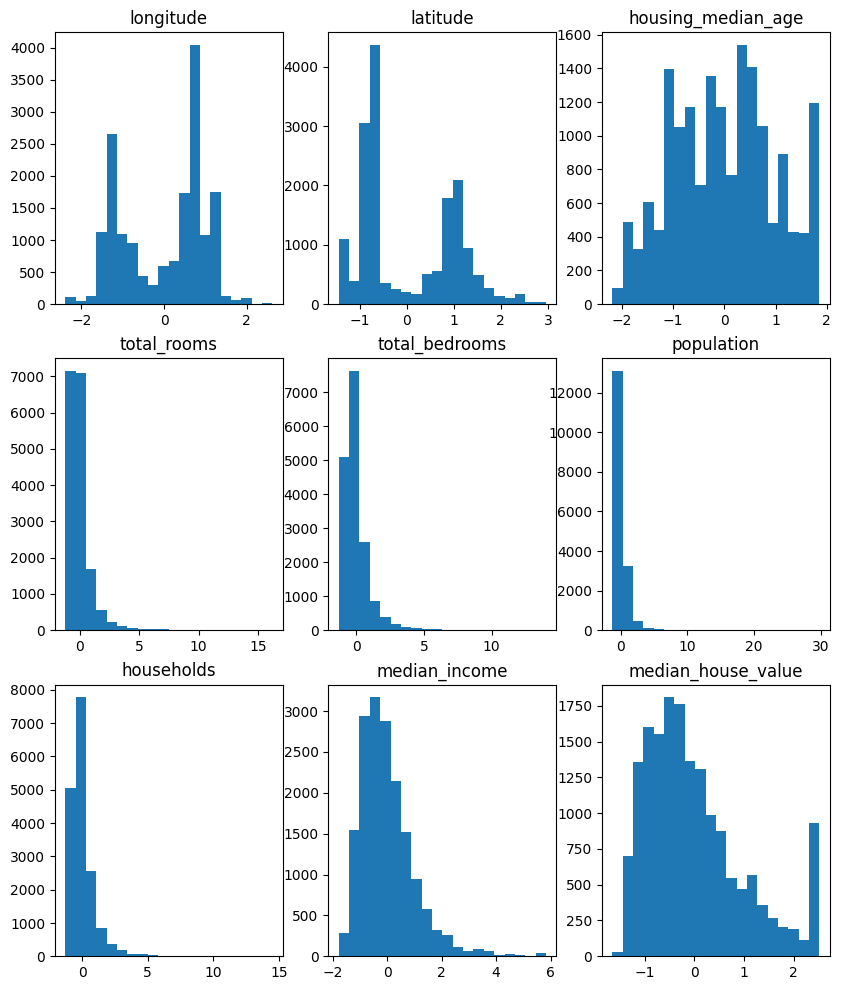

In [ ]:
plt.figure(figsize=(10, 12))
cols = df.columns
plt_size = int(np.sqrt(len(cols) - 1)) + 1

for i, col in enumerate(cols):
    plt.subplot(plt_size, int((len(cols) - 1) / plt_size) + 1, i + 1)
    plt.title(col)
    plt.hist(df[col], bins=20)

# Prepare

In [ ]:
from pandas import DataFrame

class Normalise:
    def __init__(self, standart: bool = True):
        self.coefs = None
        self.standart = standart

    def fit_transform(self, data: DataFrame):
        self.fit(data)
        return self.transform(data)

    def fit(self, data: DataFrame):
        if self.standart:
            self.coefs = pd.concat({"mean": data.mean(), "std": data.std()}, axis = 1)
        else:  # Min-Max
            self.coefs = pd.concat({"min": data.min(), "max": data.max()}, axis = 1)

    def transform(self, data: DataFrame):
        if self.coefs is None:
            raise Exception("Can't transform without train")

        if set(data.columns) ^ set(self.coefs.index):
            raise Exception("Columns of data not matching train data!")

        if self.standart:
            return (data - self.coefs['mean']) / self.coefs['std']
        else:
            return (data - self.coefs['min']) / (self.coefs['max'] - self.coefs['min'])

    def restore(self, data: DataFrame):
        if self.coefs is None:
            raise Exception("Can't restore without train")

        rest_df = DataFrame()

        for col in data.columns:
            coef = self.coefs.iloc[col]

            if self.standart:
                rest_df[col] = data[col] * coef['std'] + coef['mean']
            else:
                rest_df[col] = data[col] * (self.coefs['max'] - self.coefs['min']) + coef['min']

        return rest_df

In [ ]:
scaler = Normalise(standart = True)
df_norm = scaler.fit_transform(df)
# df_norm = df

df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,2.619288,-0.671500,-1.079639,1.361655,1.764152,-0.361173,-0.075996,-1.252506,-1.210522
1,2.539494,-0.573248,-0.761850,2.296540,3.230346,-0.261858,-0.099401,-1.081451,-1.096713
2,2.494610,-0.905436,-0.920744,-0.882436,-0.866931,-0.955326,-0.999223,-1.170071,-1.048430
3,2.489623,-0.928830,-1.159087,-0.524171,-0.480216,-0.796769,-0.715753,-0.362590,-1.154480
4,2.489623,-0.961581,-0.682402,-0.545731,-0.506313,-0.701809,-0.622130,-1.026424,-1.222593


In [ ]:
def train_test_split(data, labels, train_size=0.8, shuffle=True, random_state=None):
    assert data.shape[0] == labels.shape[0]

    sz = data.shape[0]

    if shuffle:
        np.random.seed(random_state)
        perm = np.random.permutation(sz)
        data = data.iloc[perm]
        labels = labels.iloc[perm]

    if 0 < train_size < 1:
        train_size = int(train_size * sz)

    return data[:train_size], data[train_size:], labels[:train_size], labels[train_size:]

# Train

In [ ]:
class LinearRegression:
    def __init__(self):
        self.weights = None
        self.intercept = None

    @staticmethod
    def prepare_data(data):
        if isinstance(data, DataFrame):
            data = data.to_numpy()
        if len(data.shape) < 2:
            data = np.expand_dims(data, -1)
        return data

    def fit(self, data, labels, learning_rate=0.01, epochs=100):
        assert data.shape[0] == labels.shape[0]

        data = type(self).prepare_data(data)
        labels = type(self).prepare_data(labels)

        # self.weights = np.random.normal(-1, 1, (data.shape[1], 1))
        self.weights = np.zeros((data.shape[1], 1))
        self.intercept = np.zeros(1) # np.random.rand(1)

        train_size = data.shape[0]

        for i in range(epochs):
            diff = self.predict(data) - labels
            dcost_dm = np.dot(data.T, diff) * 2 / train_size
            dcost_dc = diff.sum() * 2 / train_size

            prev_weights = self.weights.copy()
            self.weights -= learning_rate * dcost_dm
            self.intercept -= learning_rate * dcost_dc

            #if np.max(np.abs(self.weights - prev_weights)) < learning_rate:
            #    print("Early exit on epoch", i + 1)
            #    return self.weights, self.intercept

        return self.weights, self.intercept

    def fit_linalg(self, data, labels):
        assert data.shape[0] == labels.shape[0]

        data = type(self).prepare_data(data)
        labels = type(self).prepare_data(labels)

        # Add biases
        data = np.concatenate((data, np.ones((data.shape[0], 1))), axis=1)

        weights = np.linalg.solve(np.dot(data.T, data), np.dot(data.T, labels))
        self.weights = weights[:-1]
        self.intercept = weights[-1]

    def predict(self, data):
        if self.weights is None or self.intercept is None:
            raise Exception("Can't predict without train!")

        data = type(self).prepare_data(data)

        return np.dot(data, self.weights) + self.intercept

    def score(self, data, labels, score_type: str = "mse"):
        if self.weights is None or self.intercept is None:
            raise Exception("Can't count cost without train!")

        data = type(self).prepare_data(data)
        labels = type(self).prepare_data(labels)

        if score_type == 'mse':
            return np.mean(np.square(self.predict(data) - labels))
        elif score_type == 'mae':
            return np.mean(np.abs(self.predict(data) - labels))
        elif score_type == 'r2':
            ss_res = np.sum(np.square(self.predict(data) - labels))
            ss_total = np.sum(np.square(labels - labels.mean()))
            return 1 - ss_res / ss_total
        else:
            raise Exception(f"Can't find type of score: {score_type}!")


In [ ]:
def process_model(data, linalg: bool = True):
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop('median_house_value', axis=1),
        data['median_house_value'],
        random_state=10
    )

    model = LinearRegression()

    if linalg:
        model.fit_linalg(X_train, y_train)
    else:
        model.fit(X_train, y_train)

    print(
        f"Model train: MSE - {model.score(X_train, y_train):.4f}, " \
        f"MAE - {model.score(X_train, y_train, score_type = 'mae'):.4f}, " \
        f"R2 - {model.score(X_train, y_train, score_type = 'r2'):.4f}"
    )

    print(
        f"Model test: MSE - {model.score(X_test, y_test):.4f}, " \
        f"MAE - {model.score(X_test, y_test, score_type = 'mae'):.4f}, " \
        f"R2 - {model.score(X_test, y_test, score_type = 'r2'):.4f}"
    )
    print("Result weights:", ", ".join([str(round(w[0], 4)) for w in model.weights]))
    print("Intercept:", round(model.intercept[0], 4))

    return model

## Gradient descent

In [ ]:
model = process_model(df_norm, linalg = False)

Model train: MSE - 0.4565, MAE - 0.5088, R2 - 0.5472
Model test: MSE - 0.4272, MAE - 0.4956, R2 - 0.5574
Result weights: -0.1135, -0.1549, 0.1536, 0.0598, 0.0439, -0.0948, 0.0568, 0.5947
Intercept: 0.0065


## System of linear equations solution

In [ ]:
model = process_model(df_norm, linalg = True)

Model train: MSE - 0.3630, MAE - 0.4413, R2 - 0.6399
Model test: MSE - 0.3414, MAE - 0.4291, R2 - 0.6462
Result weights: -0.7526, -0.7962, 0.1236, -0.1639, 0.4136, -0.374, 0.165, 0.6689
Intercept: 0.0055


## Sklearn LinearRegression result

In [ ]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(
    df_norm.drop('median_house_value', axis=1),
    df_norm['median_house_value'],
    random_state=10
)

m = LR()
m.fit(X_train, y_train)

print(f"R2 - {r2_score(y_test, m.predict(X_test))}")
print("Result weights:", ", ".join([str(round(w, 4)) for w in m.coef_]))
print("Intercept:", m.intercept_)

R2 - 0.6462384007865107
Result weights: -0.7526, -0.7962, 0.1236, -0.1639, 0.4136, -0.374, 0.165, 0.6689
Intercept: 0.005495687949607727


# Different models

<Axes: >

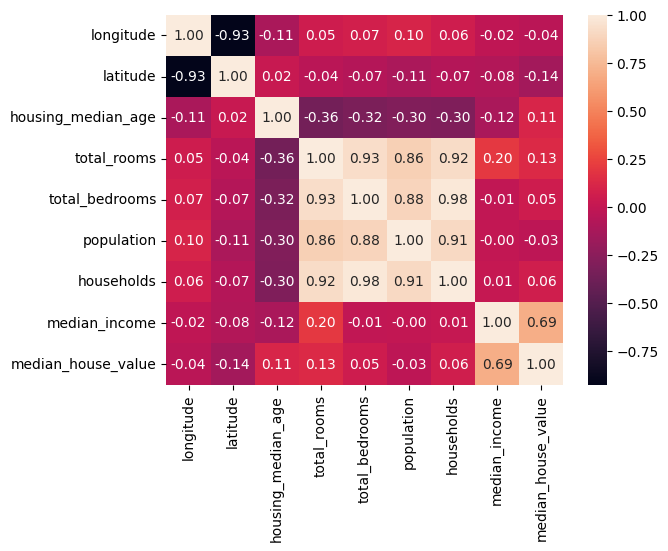

In [ ]:
import seaborn as sns

sns.heatmap(df.corr(), annot=True, fmt='.2f')

Признаки total_bedrooms, households, population и total_rooms сильно скоррелированны, так что заменим их на 1 признак методом главных компонент

Также заметим, что longitude и latitude сильно коррелируют, так что заменим их на один элемент с помощью PCA

In [ ]:
from sklearn.decomposition import PCA


def replace_with_pca(data, cols, new_col_name):
    pca = PCA(1)
    pca_data, data = data[cols], data.drop(cols, axis=1)

    data[new_col_name] = pca.fit_transform(pca_data)

    print(f"{new_col_name.title()} explained variance:", pca.explained_variance_ratio_[0])

    return data

In [ ]:
cols = ['longitude', 'latitude']

df_norm = replace_with_pca(df_norm, cols, 'coords')
df_norm.head()

Coords explained variance: 0.9626041393396064


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,coords
0,-1.079639,1.361655,1.764152,-0.361173,-0.075996,-1.252506,-1.210522,-2.326939
1,-0.761850,2.296540,3.230346,-0.261858,-0.099401,-1.081451,-1.096713,-2.201041
2,-0.920744,-0.882436,-0.866931,-0.955326,-0.999223,-1.170071,-1.048430,-2.404196
3,-1.159087,-0.524171,-0.480216,-0.796769,-0.715753,-0.362590,-1.154480,-2.417211
4,-0.682402,-0.545731,-0.506313,-0.701809,-0.622130,-1.026424,-1.222593,-2.440369


In [ ]:
# Test model

print("Back propagation model:\n")
_ = process_model(df_norm, linalg = False)

print("\nLinAlg model:\n")
_ = process_model(df_norm, linalg = True)

Back propagation model:

Model train: MSE - 0.4832, MAE - 0.5270, R2 - 0.5206
Model test: MSE - 0.4530, MAE - 0.5134, R2 - 0.5306
Result weights: 0.1625, 0.0581, 0.044, -0.0932, 0.0592, 0.6032, -0.0293
Intercept: 0.0065

LinAlg model:

Model train: MSE - 0.4320, MAE - 0.4842, R2 - 0.5714
Model test: MSE - 0.4079, MAE - 0.4724, R2 - 0.5773
Result weights: 0.2075, -0.3622, 0.3307, -0.3557, 0.4489, 0.7888, -0.0271
Intercept: 0.0059


In [ ]:
cols = ['total_bedrooms', 'households', 'population', 'total_rooms']

df_norm = replace_with_pca(df_norm, cols, 'house_info')
df_norm.head()

House_Info explained variance: 0.9351481691676781


,housing_median_age,median_income,median_house_value,coords,house_info
0,-1.079639,-1.252506,-1.210522,-2.326939,1.354509
1,-0.761850,-1.081451,-1.096713,-2.201041,2.597752
2,-0.920744,-1.170071,-1.048430,-2.404196,-1.851773
3,-1.159087,-0.362590,-1.154480,-2.417211,-1.256411
4,-0.682402,-1.026424,-1.222593,-2.440369,-1.186331


<Axes: >

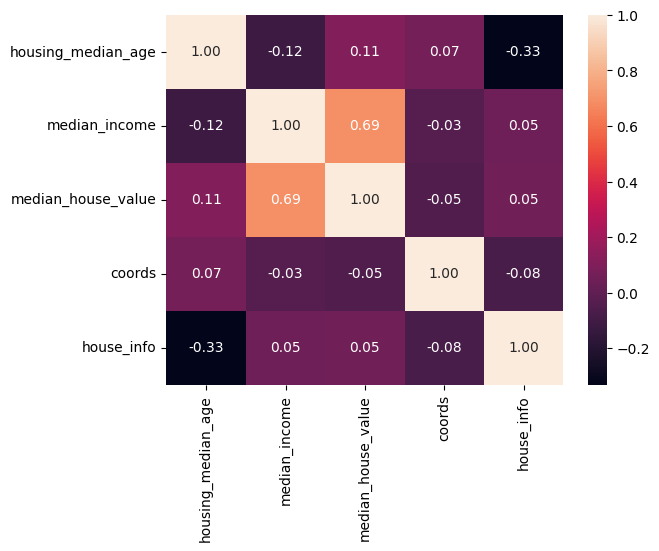

In [ ]:
sns.heatmap(df_norm.corr(), annot=True, fmt='.2f')

In [ ]:
# Test model

print("Back propagation model:\n")
_ = process_model(df_norm, linalg = False)

print("\nLinAlg model:\n")
_ = process_model(df_norm, linalg = True)

Back propagation model:

Model train: MSE - 0.4957, MAE - 0.5337, R2 - 0.5083
Model test: MSE - 0.4649, MAE - 0.5194, R2 - 0.5183
Result weights: 0.1606, 0.6098, -0.0259, 0.0353
Intercept: 0.0066

LinAlg model:

Model train: MSE - 0.4828, MAE - 0.5189, R2 - 0.5210
Model test: MSE - 0.4536, MAE - 0.5069, R2 - 0.5299
Result weights: 0.2219, 0.7137, -0.0248, 0.0445
Intercept: 0.0061
